In [2]:
import matplotlib.pyplot as plt
import keras
import random
import pandas as pd
import numpy as np
from functools import partial
from math import *
import cv2 as cv
from PIL import Image, ImageOps
from IPython.display import display 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
from scipy import stats
import sklearn 
import sklearn.feature_extraction

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [177]:
def show_bgrimg(image):#for diplaying bgr images
    plt.figure(figsize=(12, 10), dpi=80)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()
def show_rgbimg(image):#for displaying rgb images
    plt.figure(figsize=(12, 10), dpi=80)
    plt.imshow(image)
    plt.show()
def show_bnw(image):#for displaying grayscale images 
    plt.figure(figsize=(12, 10), dpi=80)
    plt.imshow(image,cmap="gray")
    plt.show()

In [4]:
m = tf.keras.metrics.MeanSquaredError()
m.update_state([[0, 1], [0, 0]], [[1, 1], [0, 0]])
MSE=m.result().numpy()
print(type(MSE))

<class 'numpy.float32'>


In [5]:
def PSNR_tf(y_grdtrth,y_pred):
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(y_grdtrth,y_pred)
    MSE=m.result().numpy()
    
    result=10*log10((255**2)/MSE)
    return result

In [57]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [6]:
#sample image
sample=cv.imread('sage.png')

In [7]:
#function to finc DCT(discrete cosine transform) of an image
def convert_img_to_dct(image):
    imagefloat=image.astype("float")
    dct_img=cv.dct(imagefloat)
    return dct_img

#function to convert Img from DCT
def convert_dct_to_img(dct_img):
    image=cv.idct(dct_img)
    return image
    

In [8]:
#function to convert to ycbcr
def conv_ycbcr(image):
    height=image.shape[0]
    width=image.shape[1]
    ycbcr_img=cv.cvtColor(image, cv.COLOR_BGR2YCR_CB)
    return np.resize((ycbcr_img[:,:,0]).flatten(),(height,width,1))


In [9]:
def patch_extraction(image,subw,subh):
    result=[]
    n_x=image.shape[1]//subw
    n_y=image.shape[0]//subh
    for i in range(n_x):
        for j in range(n_y):
            result.append(image[j*subh:(j+1)*subh:1,i*subw:(i+1)*subw:1])
    return result


In [10]:

def generateSubImage (file,hori,ver):
  try: 
    img  = Image.open(file) 
  except IOError:
    pass

  width, height = img.size
  horizontal = width//hori
  vertical = height//ver

  retval = []

  for i in range(0,horizontal):
      for j in range(0,vertical):
        left = hori*i
        top = ver*j
        right = hori*(i+1)
        bottom = ver*(j+1)
        im2 = img.crop((left, top, right, bottom))
        retval.append(im2)
  return retval

In [11]:
#function for bilateral filter and bicubic interpolation
def preprocessing(image,scale=2):
    image=cv.cvtColor(image, cv.COLOR_BGR2YCR_CB)
    image=image[:,:,0]
    width=image.shape[1]
    height=image.shape[0]

    resized_img=cv.resize(image,(width*scale,height*scale), interpolation=cv.INTER_CUBIC)
    resized_img=np.resize(resized_img.flatten(),(height*scale,width*scale,1))
    resized_img = resized_img.astype('float32')
    return resized_img

In [45]:
print(preprocessing(train_x[i]))

[[[ 45.]
  [ 72.]
  [116.]
  ...
  [110.]
  [115.]
  [118.]]

 [[ 49.]
  [ 76.]
  [121.]
  ...
  [110.]
  [118.]
  [123.]]

 [[ 54.]
  [ 82.]
  [130.]
  ...
  [111.]
  [123.]
  [130.]]

 ...

 [[ 47.]
  [ 44.]
  [ 40.]
  ...
  [107.]
  [ 82.]
  [ 66.]]

 [[ 52.]
  [ 48.]
  [ 40.]
  ...
  [114.]
  [ 93.]
  [ 80.]]

 [[ 56.]
  [ 50.]
  [ 39.]
  ...
  [118.]
  [100.]
  [ 89.]]]


In [12]:
def bicubic_resize(layer_output,image):
    resized_img=cv.resize(image, layer_output, interpolation=cv.INTER_CUBIC)
    resized_img=np.resize(resized_img.flatten(),tuple(list(layer_output)+[1]))
    return resized_img

In [13]:
print(sample.shape)
processed_sample=preprocessing(sample)
print(processed_sample.shape)

(1080, 1920, 3)
(2160, 3840, 1)


In [14]:
#loading datasets
tfds.list_builders()


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiab

In [15]:
ds,ds_info = tfds.load('div2k', split='train', shuffle_files=True,with_info=True)
print(type(ds))
print(ds_info)

<class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>
tfds.core.DatasetInfo(
    name='div2k',
    full_name='div2k/bicubic_x2/2.0.0',
    description="""
    DIV2K dataset: DIVerse 2K resolution high quality images as used for the challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018)
    """,
    config_description="""
    Uses bicubic_x2 data.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/DIV2K/',
    data_path='C:\\Users\\htg_sensei\\tensorflow_datasets\\div2k\\bicubic_x2\\2.0.0',
    download_size=4.68 GiB,
    dataset_size=4.68 GiB,
    features=FeaturesDict({
        'hr': Image(shape=(None, None, 3), dtype=tf.uint8),
        'lr': Image(shape=(None, None, 3), dtype=tf.uint8),
    }),
    supervised_keys=('lr', 'hr'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=800, num_shards=64>,
        'validation': <SplitInfo num_examples=100, num_shards=8>,
    },
    citation="""@InProceedings{Agustsson_2017_CVPR_W

In [16]:
#to show the functions of "ds"
print(dir(ds))

['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_checkpoint_dependencies', '_consumers', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_ref', '_input_dataset', '_inputs', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_map_resources', '_maybe_initialize_trackable', '_name_b

['hr', 'lr']
(1356, 2040, 3) (678, 1020, 3)


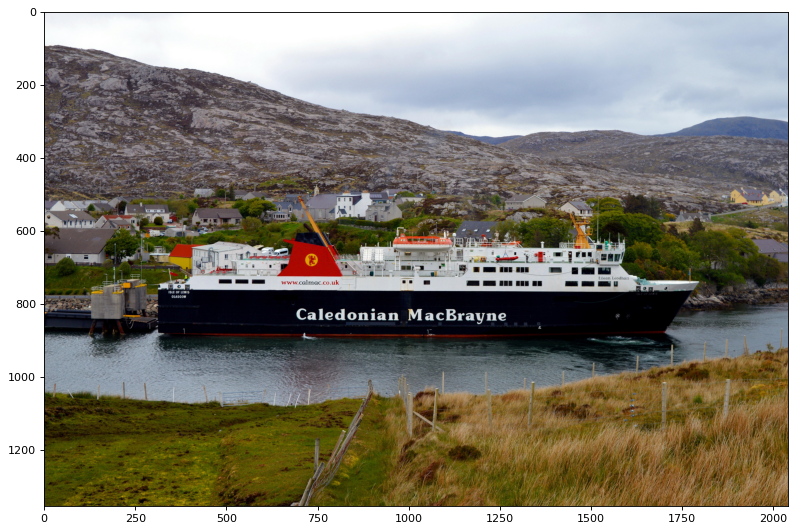

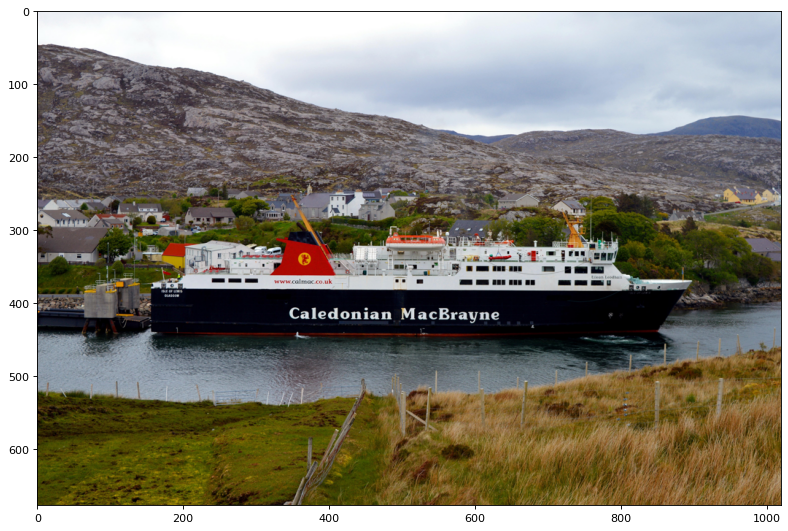

In [17]:
#testing if the dataset has loaded
for example in ds.take(1):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  hr_img = example["hr"]
  lr_img = example["lr"]
  print(hr_img.shape, lr_img.shape)
show_rgbimg(np.array(hr_img))
show_rgbimg(np.array(lr_img))

How to extract data from a tensorflow dataset: https://www.tensorflow.org/datasets/overview

In [18]:
#extracting images from dataset
train_x=[]
train_y=[]
no_of_images=100
i=0
for sample in ds:
    train_x.append(np.array(sample["lr"]))
    train_y.append(np.array(sample["hr"]))
    i+=1
    if(i==no_of_images):
        break

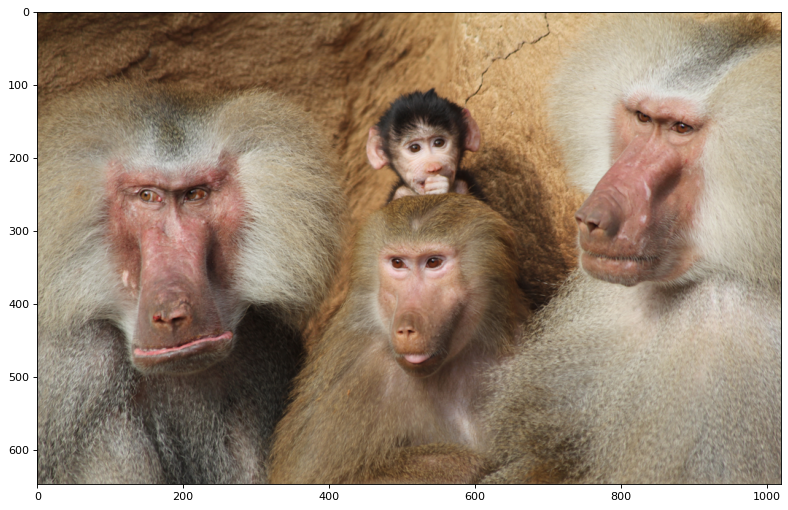

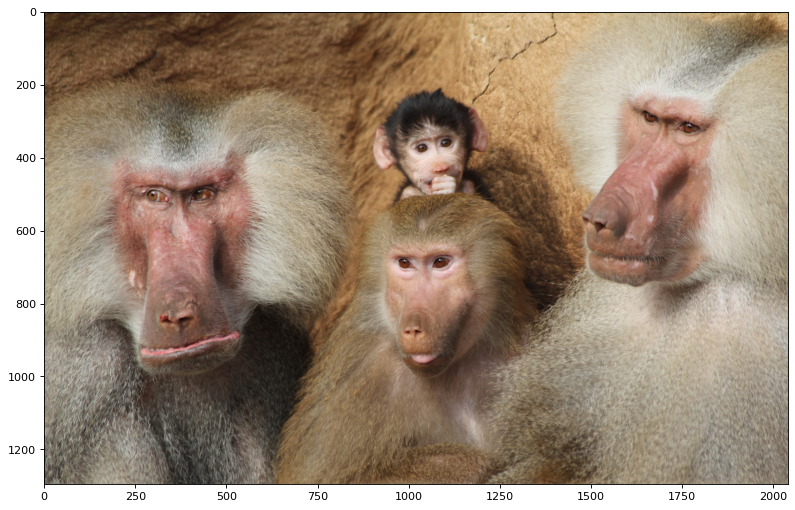

In [19]:
#testing
plt.figure(figsize=(12, 10), dpi=80)
plt.imshow(train_x[1])
show_rgbimg(train_y[1])

#testing the functions
show_rgbimg(train_x[2])
print(train_x[2].shape)
show_rgbimg(train_x[2])
print(train_y[2].shape)
trial=preprocessing(train_x[2],2)
show_bnw(trial)
print(trial.shape)
ycbcr=conv_ycbcr(train_y[2])
show_bnw(ycbcr)
l=conv_ycbcr(train_x[2])
show_bnw(l)

In [20]:
#shape of the images stored
for i in range(5):
    print(train_x[i].shape,train_y[i].shape)

(678, 1020, 3) (1356, 2040, 3)
(648, 1020, 3) (1296, 2040, 3)
(666, 1020, 3) (1332, 2040, 3)
(678, 1020, 3) (1356, 2040, 3)
(678, 1020, 3) (1356, 2040, 3)


In [21]:
#initializing parameters
batch_size=30
height=50
width=50

In [22]:
#pre-processing
processed_images_x=list(map(preprocessing,train_x))
grayscale_images_y=list(map(conv_ycbcr,train_y))
print(processed_images_x[2].shape)
print(grayscale_images_y[2].shape)

(1332, 2040, 1)
(1332, 2040, 1)


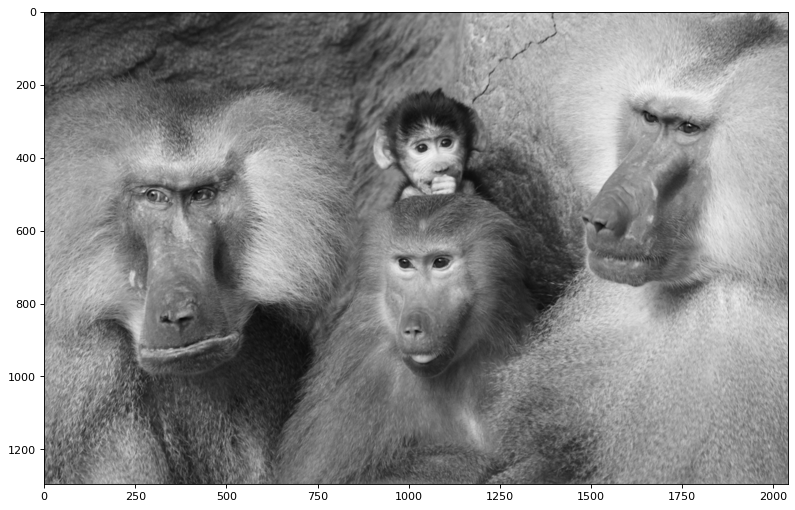

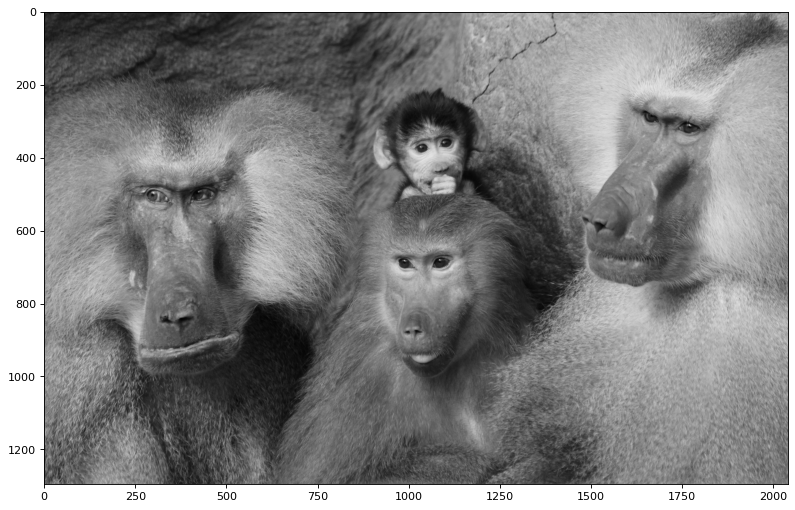

In [23]:
show_bnw(processed_images_x[1])
show_bnw(grayscale_images_y[1])

In [24]:
#cropping
cropped_images_x=np.array(patch_extraction(processed_images_x[0],height,width))
cropped_images_y=np.array(patch_extraction(grayscale_images_y[0],height,width))
for element in processed_images_x[1:]:
    cropped_images_x=np.append(cropped_images_x,patch_extraction(element,height,width),axis=0)
for element in grayscale_images_y[1:]:
    cropped_images_y=np.append(cropped_images_y,patch_extraction(element,height,width),axis=0)

    
shape_x=cropped_images_x.shape
shape_y=cropped_images_y.shape


normalized_cropped_images_x=np.resize(stats.zscore(cropped_images_x.flatten()),shape_x)


normalized_cropped_images_y=cropped_images_y/255


(108080, 50, 50, 1) (108080, 50, 50, 1)
[[[[ 0.08226972]
   [ 0.08226972]
   [ 0.06774795]
   ...
   [-0.12103506]
   [-0.1500786 ]
   [-0.20816568]]

  [[ 0.1403568 ]
   [ 0.12583503]
   [ 0.12583503]
   ...
   [-0.04842621]
   [-0.07746975]
   [-0.13555683]]

  [[ 0.21296565]
   [ 0.21296565]
   [ 0.21296565]
   ...
   [ 0.05322618]
   [ 0.03870441]
   [-0.01938267]]

  ...

  [[-0.52764463]
   [-0.52764463]
   [-0.51312286]
   ...
   [-0.5421664 ]
   [-0.52764463]
   [-0.52764463]]

  [[-0.52764463]
   [-0.52764463]
   [-0.52764463]
   ...
   [-0.5421664 ]
   [-0.52764463]
   [-0.52764463]]

  [[-0.52764463]
   [-0.52764463]
   [-0.52764463]
   ...
   [-0.52764463]
   [-0.52764463]
   [-0.52764463]]]


 [[[-0.51312286]
   [-0.51312286]
   [-0.52764463]
   ...
   [-0.52764463]
   [-0.51312286]
   [-0.51312286]]

  [[-0.51312286]
   [-0.51312286]
   [-0.52764463]
   ...
   [-0.52764463]
   [-0.51312286]
   [-0.51312286]]

  [[-0.51312286]
   [-0.52764463]
   [-0.5421664 ]
   ...
   [-

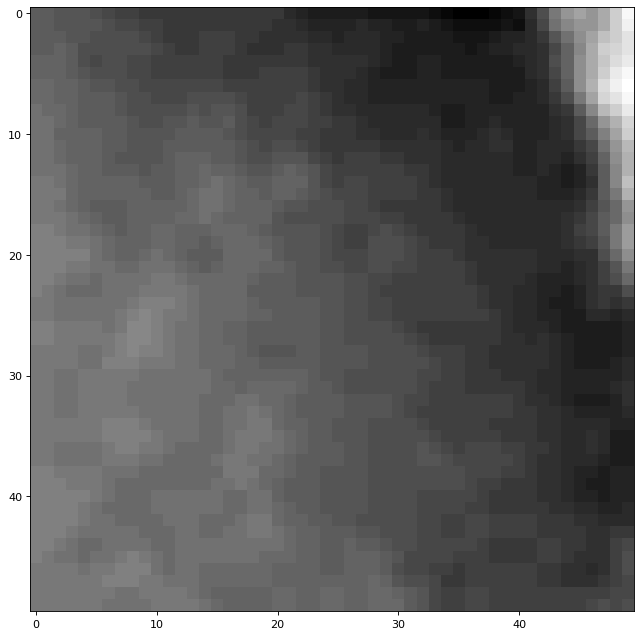

In [64]:
#testing
print(shape_x,shape_y)

print(normalized_cropped_images_x)
print(normalized_cropped_images_y)
show_bnw(np.resize(cropped_images_x[10],(height,width)))

In [ ]:
#network=models.load_model('without_dct_E20_B30_I5000')

In [257]:
#network architecture

network=models.Sequential()
network.add(layers.Conv2D(64, (9,9),activation='relu',input_shape=(height,width,1),name='first'))
network.add(layers.Conv2D(32,(1,1),activation='relu',name='second'))
network.add(layers.Conv2D(1,(5,5),activation='relu',name='last'))

In [258]:
network.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Conv2D)               (None, 42, 42, 64)        5248      
_________________________________________________________________
second (Conv2D)              (None, 42, 42, 32)        2080      
_________________________________________________________________
last (Conv2D)                (None, 38, 38, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [69]:
last_output=network.get_layer('last').output_shape[1:3]
print(last_output)

(38, 38)


In [71]:
resize=partial(bicubic_resize,last_output)
resized_normalized_cropped_images_y=np.array(list(map(resize,normalized_cropped_images_y)))

In [261]:
print(resized_normalized_cropped_images_y.shape)
print(normalized_cropped_images_y.shape)
print(normalized_cropped_images_x.shape)

(109240, 38, 38, 1)
(109240, 50, 50, 1)
(109240, 50, 50, 1)


In [262]:
network.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
history = network.fit(normalized_cropped_images_x[:100000], resized_normalized_cropped_images_y[:100000],batch_size=30,epochs=20)

Epoch 1/20
3334/3334 [==============================] - 5863s 2s/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 2/20
3334/3334 [==============================] - 256s 77ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 3/20
3334/3334 [==============================] - 253s 76ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 4/20
3334/3334 [==============================] - 252s 76ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 5/20
3334/3334 [==============================] - 247s 74ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 6/20
3334/3334 [==============================] - 246s 74ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 7/20
3334/3334 [==============================] - 241s 72ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 8/20
3334/3334 [==============================] - 251s 75ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 9/20
3334/3334 [==============================] - 244s 73ms/step - loss: 0.

KeyboardInterrupt: 

In [65]:
network=models.load_model('without_dct_E20_B30_I100000')

In [66]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Conv2D)               (None, 42, 42, 64)        5248      
_________________________________________________________________
second (Conv2D)              (None, 42, 42, 32)        2080      
_________________________________________________________________
last (Conv2D)                (None, 38, 38, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [74]:
predictions=network.predict(normalized_cropped_images_x[100000:])

Processed input


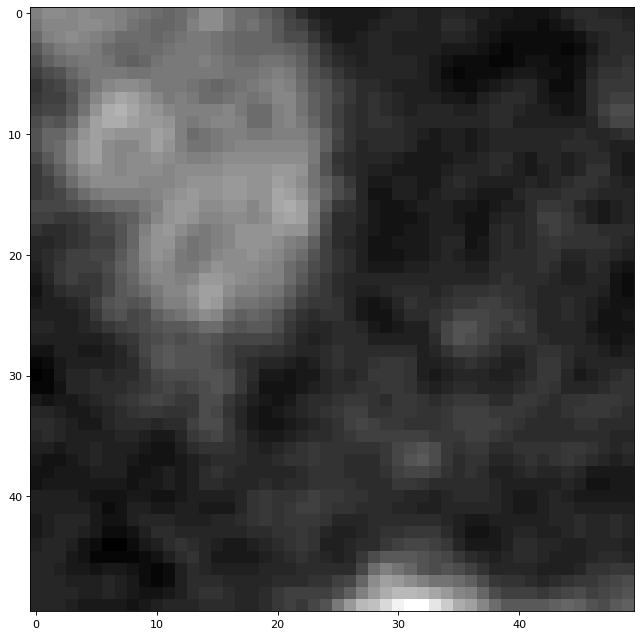

Predicted


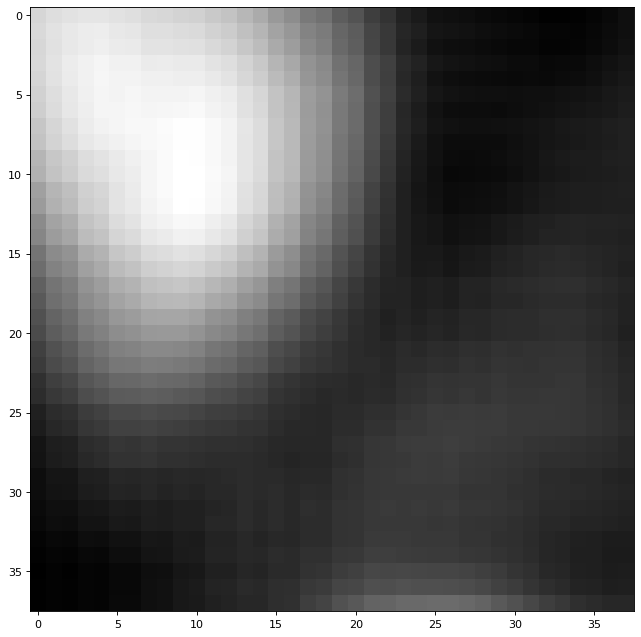

Ground Truth


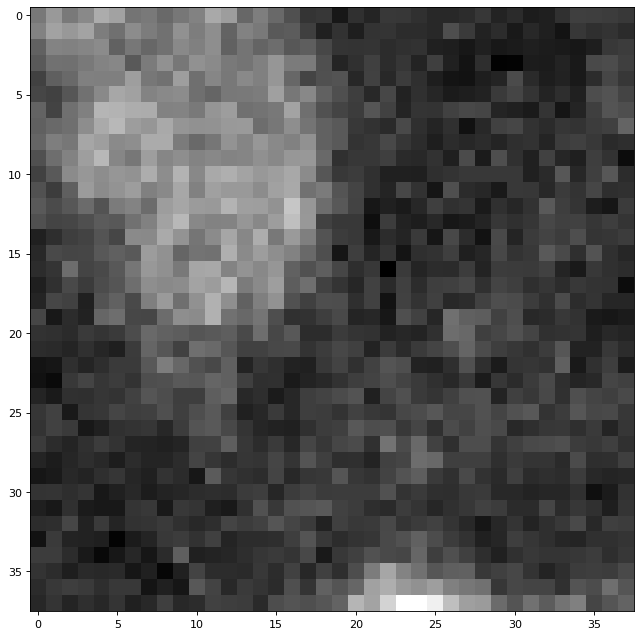

In [75]:
z=105010
print("Processed input")
show_bnw(np.resize(cropped_images_x[z].flatten(),(height,width)))
print("Predicted")
show_bnw(np.resize(predictions[z-100000].flatten(),last_output))
print("Ground Truth")
show_bnw(np.resize((resized_normalized_cropped_images_y[z]*255).flatten(),last_output))


In [76]:
sum_bicubic=0
sum_predicted=0
for z in range(100000,109000,1):
    psnr_proc=tf.image.psnr(np.resize(normalized_cropped_images_x[z].flatten(),(height,width,1)),np.resize(resized_normalized_cropped_images_y[z].flatten(),(height,width,1)),1)
    psnr_pred=tf.image.psnr(np.resize(predictions[z-100000].flatten(),(height,width,1)),np.resize(resized_normalized_cropped_images_y[z].flatten(),(height,width,1)),1)
    sum_bicubic+=psnr_proc
    sum_predicted+=psnr_pred
print("**************")
print(sum_bicubic/9000)
print(sum_predicted/9000)

IndexError: index 108080 is out of bounds for axis 0 with size 108080

In [77]:
results = network.evaluate(normalized_cropped_images_x[100000:],resized_normalized_cropped_images_y[100000:], batch_size=30)
print(results)

270/270 [==============================] - 5s 18ms/step - loss: 0.0076 - mean_squared_error: 0.0076
[0.00764361210167408, 0.007643610239028931]


In [211]:
#final class for super resolution

class SuperResolution:
    def __init__(self, image, type='bgr',scale=2):
        self.image=image
        self.network=models.load_model('without_dct_E20_B30_I100000')
        self.shape=image.shape
        self.input_dim=(50,50)
        self.type=type
        self.scale=2
        self.n_x=(self.image.shape[1]*self.scale)//(50)
        self.n_y=(self.image.shape[0]*self.scale)//(50)
        self.output=None
        self.output_cb=None
        self.output_cr=None
        self.output_y=None
        self.predictions=None

        
    #displaying functions
    def show_bgrimg(self,image):#for diplaying bgr images
        plt.figure(figsize=(12, 10), dpi=80)
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.show()
    def show_rgbimg(self,image):#for displaying rgb images
        plt.figure(figsize=(12, 10), dpi=80)
        plt.imshow(image)
        plt.show()
    def show_bnw(self,image):#for displaying grayscale images 
        plt.figure(figsize=(12, 10), dpi=80)
        plt.imshow(image,cmap="gray")
        plt.show()
    
    #summary of model to be used for super resolution
    def model_summary(self):
        self.network.summary()
    
    #dividing the given image into sub-images
    def __patch_extraction(self,image,stride=0):
        result=[]
        print("image",image.shape)
        resized_img=cv.resize(image, ((image.shape[1]//50)*50,(image.shape[0]//50)*50), interpolation=cv.INTER_CUBIC)
        resized_img=np.resize(resized_img,((image.shape[0]//50)*50,(image.shape[1]//50)*50,1))
        print("cv",resized_img.shape)
        print(self.n_x)
        if stride==0:
            for i in range(image.shape[0]//50):
                for j in range(image.shape[1]//50):
                    result.append(resized_img[i*50:(i+1)*50,j*50:(j+1)*50])
        else:
            for i in range((image.shape[0]//50)*2-1):
                for j in range((image.shape[1]//50)*2-1):
                    result.append(resized_img[i*25:i*25+50,j*25:j*25+50])
        return np.array(result)
    
    
    def __preprocessing(self):
        ycrcb_img=None
        if self.type=='bgr':
            ycrcb_img=cv.cvtColor(self.image, cv.COLOR_BGR2YCR_CB)
        elif self.type=='rgb':
            yrbcb_img=cv.cvtColor(self.image, cv.COLOR_RGB2YCR_CB)
        else:
            assert(False)

        width=self.shape[1]
        height=self.shape[0]
        
        luminance=ycrcb_img[:,:,0]

        self.output_cr=cv.resize(ycrcb_img[:,:,2],(width*self.scale,height*self.scale),interpolation=cv.INTER_CUBIC)
        self.output_cb=cv.resize(ycrcb_img[:,:,1],(width*self.scale,height*self.scale),interpolation=cv.INTER_CUBIC)
        
        resized_img=cv.resize(luminance,(width*self.scale,height*self.scale), interpolation=cv.INTER_CUBIC)
        resized_img=np.resize(resized_img.flatten(),(height*self.scale,width*self.scale,1))
        resized_img = resized_img.astype('float32')
        print("resized",resized_img.shape)
        
        return resized_img
        
    def __reconstruction(self,patches):
        img_width=self.n_x*38
        img_height=self.n_y*38
        result=np.zeros((img_height,img_width))
        try:
            for i in range(self.n_y*2-1):
                for j in range(self.n_x*2-1):
                    req_patch=patches[i*(self.n_x*2-1)+j]
                    for y in range(38):
                        for x in range(38):
                            result[i*19+y,j*19+x]+=req_patch[y,x,0]
                            
        except IndexError: 
             print("Index Error")
        return result/4
        
    def __thresholding(self,image,max_intensity):
        i,j=0,0
        for rows in image:
            i=0
            for e in rows:
                if e>max_intensity:
                    image[j,i]=max_intensity
                i+=1
            j+=1
        return image


    #predicting the higher resolution image
    def prediction(self):
        #patches=self.__patch_extraction(self.__preprocessing(),stride=1)
        
        
        
        patches=np.array(sklearn.feature_extraction.image.extract_patches_2d(self.__preprocessing(),(50,50)))
        
        
        
        print("patches",patches.shape)
        print("self.__preprocessing()",self.__preprocessing().shape)
        
        normalized=stats.zscore(np.array(patches).flatten())
        normalized=np.resize(normalized,(patches.shape[0],patches.shape[1],patches.shape[2],1))
        
        
        print("normalized",normalized.shape)
        
        
        
        predictions=self.network.predict(normalized)
        
        self.predictions=predictions*255
        
        
        
        resized_predictions=np.array(list(map(partial(bicubic_resize,(50,50)),predictions)))       
        
        resized_predictions=np.resize(resized_predictions,tuple(list(resized_predictions.shape)[:3]))
        
        
        print("resized_predictions",resized_predictions.shape)
        
        result=sklearn.feature_extraction.image.reconstruct_from_patches_2d(resized_predictions,(self.n_y*50,self.n_x*50))
        
       
        
        result=self.__thresholding(result*255,255)
        
        
        
        result=cv.resize(result,(self.shape[1]*self.scale,self.shape[0]*self.scale),interpolation=cv.INTER_CUBIC)
        
        
        
        self.output_y=result.astype(np.uint8)
        
        
        self.output=np.dstack((self.output_y,self.output_cr,self.output_cb))
        
        if self.type=="bgr":
            self.output=cv.cvtColor(self.output,cv.COLOR_YCR_CB2BGR)
        elif self.type=='rgb':
            self.output=cv.cvtColor(self.output,cv.COLOR_YCR_CB2RGB)
        
        return self.output
    
    def compare_psnr(self,expected):
        return tf.image.psnr(expected,self.output,255)
                
        

In [212]:
i=70

In [213]:
test=SuperResolution(train_x[i][:100,:100])

In [214]:
test.prediction()

resized (200, 200, 1)
patches (22801, 50, 50)
resized (200, 200, 1)
self.__preprocessing() (200, 200, 1)
normalized (22801, 50, 50, 1)
resized_predictions (22801, 50, 50)


array([[[ 38,  38,  38],
        [ 38,  38,  38],
        [ 39,  38,  40],
        ...,
        [234, 255, 255],
        [232, 255, 255],
        [230, 255, 255]],

       [[ 38,  38,  38],
        [ 38,  38,  38],
        [ 39,  38,  40],
        ...,
        [234, 255, 255],
        [232, 255, 255],
        [230, 255, 255]],

       [[ 38,  38,  38],
        [ 38,  38,  38],
        [ 38,  37,  39],
        ...,
        [234, 255, 255],
        [232, 255, 255],
        [230, 255, 255]],

       ...,

       [[143, 147, 142],
        [139, 143, 138],
        [138, 139, 137],
        ...,
        [232, 238, 251],
        [230, 239, 249],
        [230, 239, 249]],

       [[140, 143, 141],
        [136, 139, 137],
        [133, 135, 136],
        ...,
        [231, 240, 250],
        [231, 240, 250],
        [231, 240, 250]],

       [[136, 139, 137],
        [133, 135, 135],
        [130, 131, 135],
        ...,
        [232, 241, 251],
        [232, 241, 251],
        [232, 241, 251]]

Bicubic


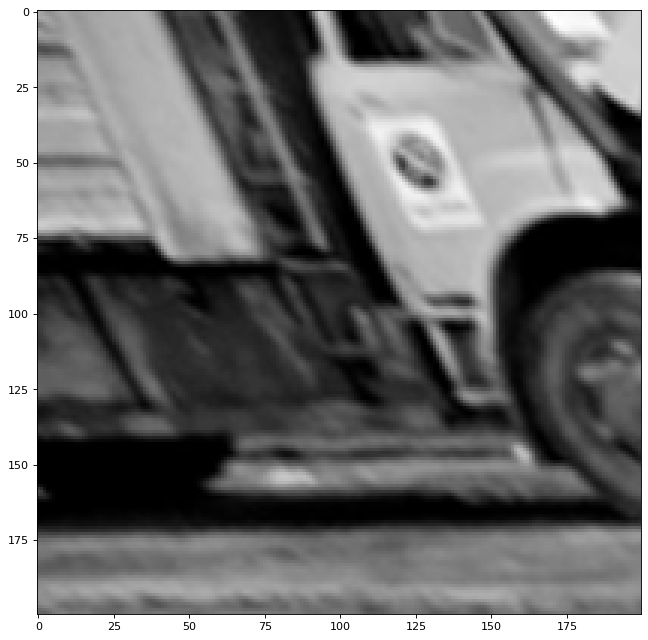

Output


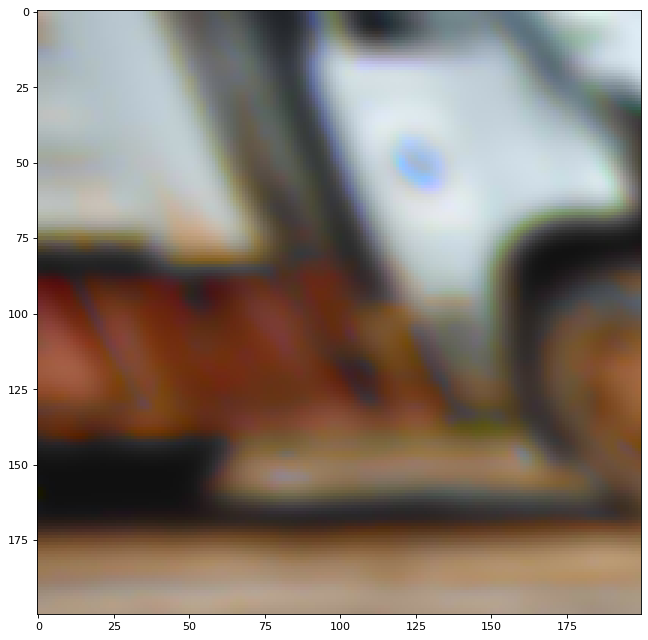

Grayscale Y


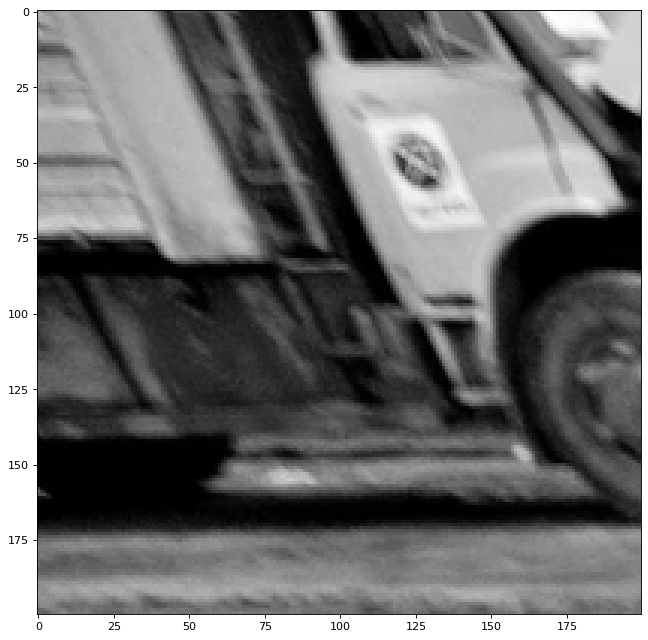

Train_Y


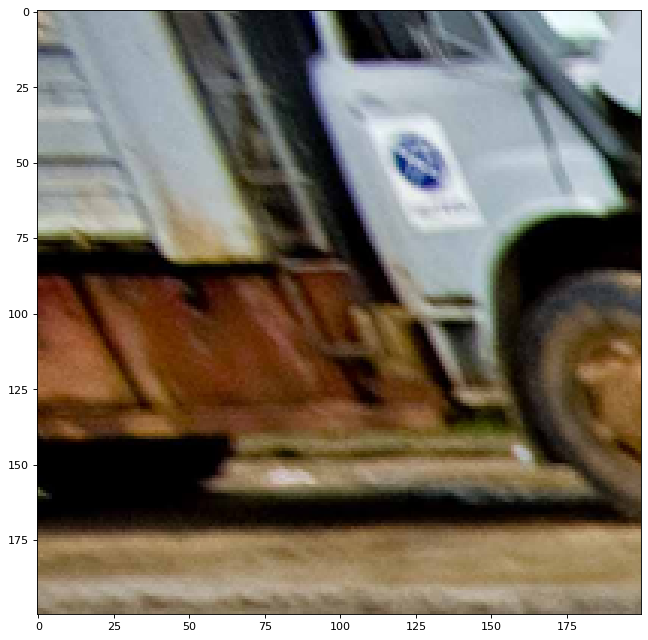

Y


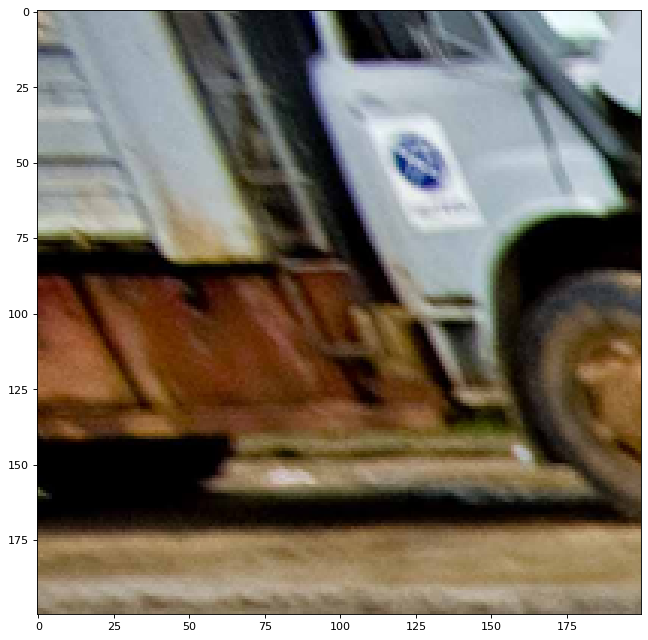

X Bicubic Whole


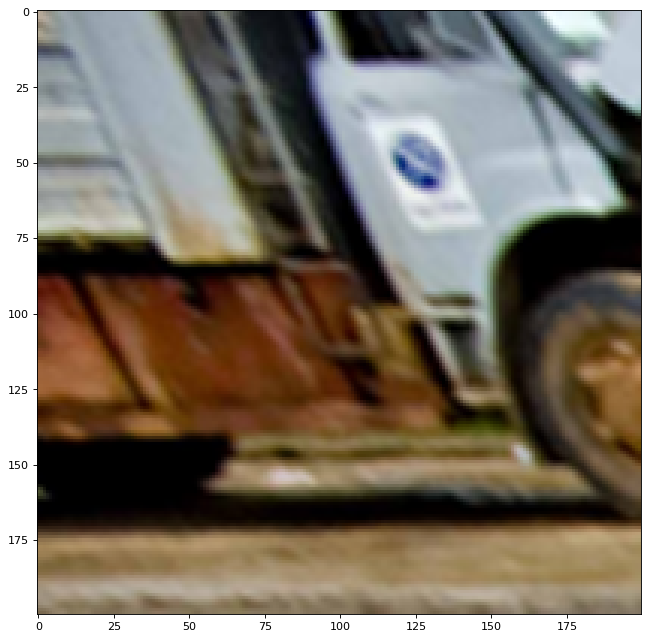

In [221]:
print("Bicubic")
show_bnw(processed_images_x[i][:200,:200])
print("Output")
show_bgrimg(test.output)
print("Grayscale Y")
show_bnw(grayscale_images_y[i][:200,:200])
print("Train_Y")
show_rgbimg(train_y[i][:200,:200])
print("Y")
show_rgbimg(train_y[i][:200,:200])
print("X Bicubic Whole")
show_rgbimg(cv.resize(train_x[i][:100,:100],(200,200),interpolation=cv.INTER_CUBIC))



In [127]:
np.mean((np.array([[[1,2],[1,2],[1,2]]]).astype(np.uint8)-np.array([[[2,3],[2,3],[2,4]]]).astype(np.uint8)))

254.83333333333334

In [101]:
tf.image.psnr(np.array([[[1,2],[1,2],[1,2]]]),np.array([[[2,3],[2,3],[2,4]]]),255)

<tf.Tensor: shape=(), dtype=float32, numpy=46.36989>

In [99]:
PSNR(np.array([[[1,2],[1,2],[1,2]]]),np.array([[[2,3],[2,3],[2,4]]]))

46.369891018122296

In [112]:
np.array([255.0]).astype(np.uint8)

array([255], dtype=uint8)

In [133]:
bicubic=cv.resize(train_x[i],(train_y[i].shape[1],train_y[i].shape[0]),interpolation=cv.INTER_CUBIC)[:200,:200]

print(PSNR(train_y[i][:200,:200],test.output))
print(PSNR(train_y[i][:200,:200],bicubic))
 

1.5903481620651774
35.64967668284418
[[[80.]
  [80.]
  [80.]
  ...
  [78.]
  [77.]
  [79.]]

 [[80.]
  [80.]
  [80.]
  ...
  [78.]
  [78.]
  [79.]]

 [[79.]
  [79.]
  [79.]
  ...
  [78.]
  [78.]
  [78.]]

 ...

 [[30.]
  [30.]
  [30.]
  ...
  [ 8.]
  [ 8.]
  [ 8.]]

 [[29.]
  [29.]
  [30.]
  ...
  [23.]
  [24.]
  [23.]]

 [[29.]
  [29.]
  [29.]
  ...
  [24.]
  [25.]
  [24.]]]


In [191]:
print(type(test.output_y))
print(processed_images_x[i][:200,:200])

<class 'NoneType'>
[[[58.]
  [58.]
  [57.]
  ...
  [54.]
  [55.]
  [55.]]

 [[58.]
  [58.]
  [58.]
  ...
  [54.]
  [55.]
  [55.]]

 [[57.]
  [57.]
  [58.]
  ...
  [54.]
  [55.]
  [55.]]

 ...

 [[67.]
  [67.]
  [68.]
  ...
  [60.]
  [60.]
  [60.]]

 [[68.]
  [68.]
  [69.]
  ...
  [60.]
  [61.]
  [61.]]

 [[68.]
  [69.]
  [69.]
  ...
  [61.]
  [61.]
  [61.]]]


In [138]:
print(processed_images_x[i][:50,:50]-bicubic_resize((50,50),test.predictions[0]))    

[[[-59.687363]
  [-59.584442]
  [-59.481506]
  ...
  [-54.480667]
  [-55.437683]
  [-55.530884]]

 [[-59.972   ]
  [-59.894043]
  [-59.824066]
  ...
  [-55.43335 ]
  [-55.36647 ]
  [-56.435135]]

 [[-61.40851 ]
  [-61.359253]
  [-61.338013]
  ...
  [-56.606445]
  [-56.489456]
  [-56.548203]]

 ...

 [[-88.280136]
  [-89.29256 ]
  [-90.29883 ]
  ...
  [-79.942764]
  [-79.97337 ]
  [-80.013916]]

 [[-88.55748 ]
  [-87.52098 ]
  [-87.46838 ]
  ...
  [-96.901   ]
  [-96.96086 ]
  [-98.01584 ]]

 [[-67.09987 ]
  [-66.992935]
  [-65.877426]
  ...
  [-89.69464 ]
  [-89.76178 ]
  [-90.8015  ]]]


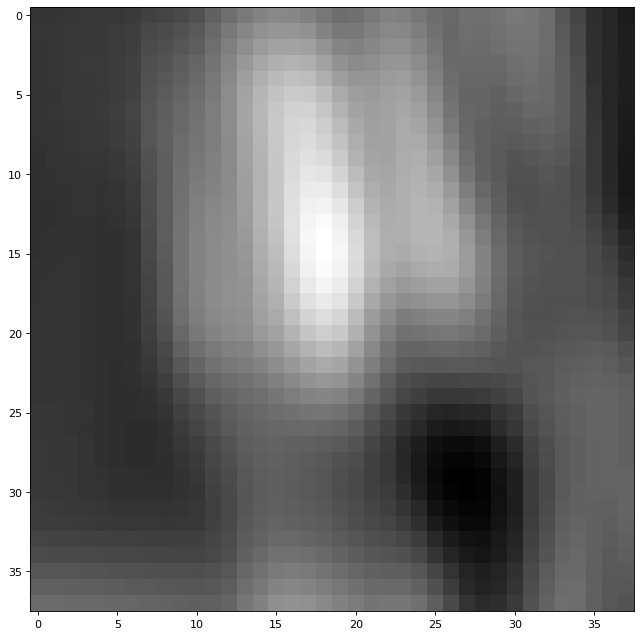

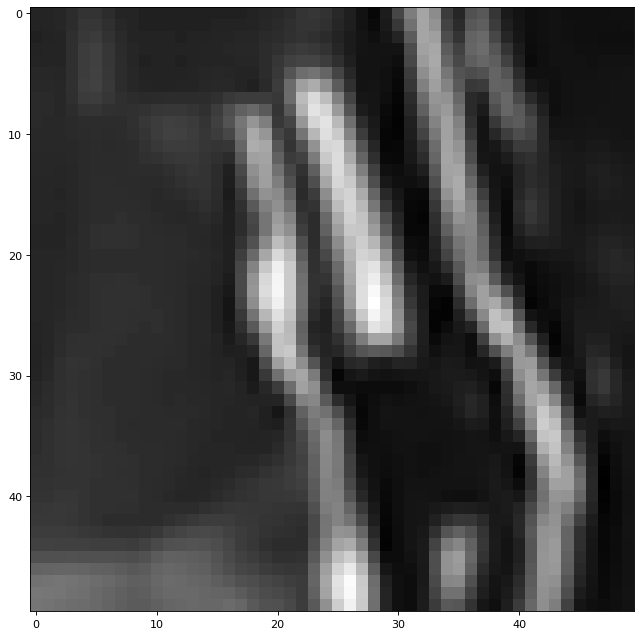

In [166]:
show_bnw(test.predictions[0])
show_bnw(processed_images_x[i][:50,:50])

In [167]:
print(PSNR(test.output_y,grayscale_images_y[i][:200,:200]))

27.644955472604753


In [168]:
print(PSNR(processed_images_x[i][:200,:200],grayscale_images_y[i][:200,:200]))

31.9426638585944


In [169]:
print(test.output_y)

[[109 108 109 ...  66  66  68]
 [109 109 110 ...  66  66  68]
 [109 109 110 ...  66  66  67]
 ...
 [255 255 255 ... 128 128 127]
 [255 255 255 ... 129 128 128]
 [255 255 255 ... 129 129 128]]


In [170]:
print(grayscale_images_y[i][:200,:200])

[[[ 34]
  [ 34]
  [ 35]
  ...
  [ 24]
  [ 25]
  [ 22]]

 [[ 34]
  [ 30]
  [ 34]
  ...
  [ 25]
  [ 26]
  [ 22]]

 [[ 33]
  [ 30]
  [ 34]
  ...
  [ 22]
  [ 27]
  [ 26]]

 ...

 [[255]
  [255]
  [255]
  ...
  [ 52]
  [ 50]
  [ 50]]

 [[255]
  [255]
  [255]
  ...
  [ 49]
  [ 49]
  [ 48]]

 [[255]
  [255]
  [255]
  ...
  [ 50]
  [ 47]
  [ 47]]]


<class 'NoneType'>


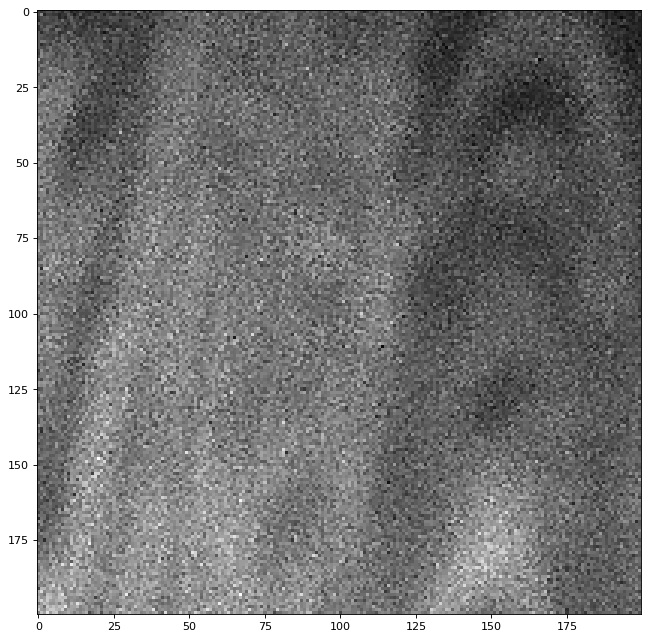

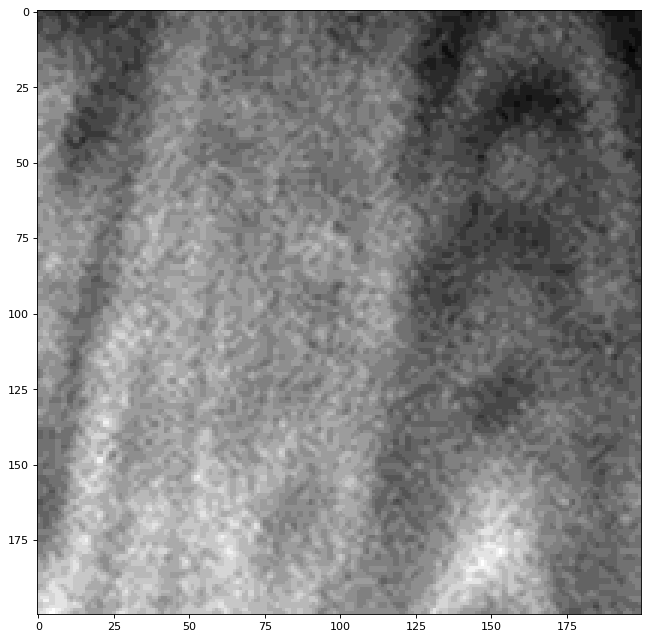

In [190]:
print(type(test.output_y))
show_bnw((grayscale_images_y[i][:200,:200]))
show_bnw(processed_images_x[i][:200,:200])

In [218]:
pred_avg=0
bicubic_avg=0
for i in range(20):
    test=SuperResolution(train_x[i][:100,:100])
    test.prediction()
    pred_avg+=PSNR(test.output,train_y[i][:200,:200])
    bicubic_avg+=PSNR(cv.resize(train_x[i],(train_y[i].shape[1],train_y[i].shape[0]),interpolation=cv.INTER_CUBIC)[:200,:200],train_y[i][:200,:200])
    print(i)
print(pred_avg/20)
print(bicubic_avg/20)

resized (200, 200, 1)
patches (22801, 50, 50)
resized (200, 200, 1)
self.__preprocessing() (200, 200, 1)
normalized (22801, 50, 50, 1)
resized_predictions (22801, 50, 50)
0
resized (200, 200, 1)
patches (22801, 50, 50)
resized (200, 200, 1)
self.__preprocessing() (200, 200, 1)
normalized (22801, 50, 50, 1)
resized_predictions (22801, 50, 50)
1
resized (200, 200, 1)
patches (22801, 50, 50)
resized (200, 200, 1)
self.__preprocessing() (200, 200, 1)
normalized (22801, 50, 50, 1)
resized_predictions (22801, 50, 50)
2
resized (200, 200, 1)
patches (22801, 50, 50)
resized (200, 200, 1)
self.__preprocessing() (200, 200, 1)
normalized (22801, 50, 50, 1)
resized_predictions (22801, 50, 50)
3
resized (200, 200, 1)
patches (22801, 50, 50)
resized (200, 200, 1)
self.__preprocessing() (200, 200, 1)
normalized (22801, 50, 50, 1)
resized_predictions (22801, 50, 50)
4
resized (200, 200, 1)
patches (22801, 50, 50)
resized (200, 200, 1)
self.__preprocessing() (200, 200, 1)
normalized (22801, 50, 50, 1)


In [210]:
test=SuperResolution(train_x[i][:100,:100])

In [206]:
print(type(test.output_y))

<class 'NoneType'>
